[View in Colaboratory](https://colab.research.google.com/github/rdorff/Data/blob/master/Lab3.ipynb)

In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available()

Total parameters:  965210


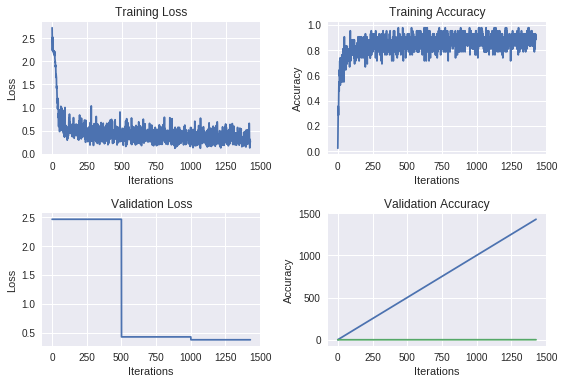

In [70]:
class Conv2d(nn.Module):
  def __init__(self, n_channels, out_channels, kernel_size, stride=1, padding=0, 
               dilation=1, groups=1, bias=True, init='orthogonal'):
    
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()
    
    self.weight = Parameter(torch.Tensor(out_channels, 
                                         n_channels // groups, 
                                         *kernel_size))
    size = list(self.weight.size())
    self.bias = Parameter(torch.Tensor(out_channels))
    
    # Uniform Intialization
    if init == 'uniform':
      self.weight.data.uniform_(-1,1)
      self.bias.data.uniform_(0,0)
      
    elif init == "xe":
      stdv = 1. / np.sqrt(np.prod(size[1:]))
      weight.data.uniform_(-stdv, stdv)
      bias.data.uniform_(-stdv, stdv)
      
    # Orthogonal Initialization
    elif init == 'orthogonal':
      X = np.random.random((size[0], np.prod(size[1:])))
      u, s, vh = np.linalg.svd(X, full_matrices=False)
      W = vh if vh.shape == X.shape else u
      W = W.reshape(size)

      self.weight.data = torch.from_numpy(W).float()
      self.bias.data.uniform_(0,0) 

  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding,self.dilation, self.groups)

class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10
    
    self.net = nn.Sequential(
      Conv2d(c, 100, (3, 3), padding=(1,1)),
      nn.ReLU(),
      Conv2d(100, 100, (3, 3), padding=(1,1)),
      nn.ReLU(),
      Conv2d(100, 100, (3, 3), padding=(1,1)),
      nn.ReLU(),
      Conv2d(100, output, (28,28), padding=(0,0)),
    )

  def forward(self, x):
    n, c, h, w = x.size()
    return self.net(x).squeeze(2).squeeze(2)

class CrossEntropyLoss(nn.Module):
  def __init__(self):
    super(CrossEntropyLoss, self).__init__()
    
  def forward(self, yhat, true_index):
    probs = torch.exp(yhat)
    log_probs = torch.log(probs / probs.sum(1, keepdim=True))
    return -log_probs[torch.arange(true_index.size(0)).long(), true_index].mean()
    

class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, train=train,
                           transform=transforms.ToTensor(),
                           download=True)
    
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y
  
  def __len__(self):
    return len(self.data)
  
  
# Initialize Training Data and Model
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist/',train=True)
model = ConvNetwork(train_dataset)
model = model.cuda()
objective = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset,
                         batch_size=42,
                         pin_memory=True)
train_losses = []

# Initialize Validation Data
validation_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist/',train=False)
validation_loader = DataLoader(validation_dataset,
                              batch_size=42,
                              pin_memory=True)
validations = []
train_accuracies = []
val_accuracies = []

# Loop through data
for epoch in range(1):
  
  loop = tqdm(total=len(train_loader), position=0, leave=False)
  
  # Train Data
  for batch, (x, y_truth) in enumerate(train_loader):
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
    
    optimizer.zero_grad()
    y_hat = model(x)
    
    loss = objective(y_hat, y_truth)
    loss.backward()
   
    train_losses.append(loss.item())
    
    accuracy = (y_hat.argmax(1) == y_truth).float().mean()
    train_accuracies.append(accuracy)
    loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, loss.item(), accuracy))
    loop.update(1)
    
    optimizer.step()
    
    if batch % 500 == 0: 
      val = np.mean([objective(model(x.cuda()), y.cuda()).item()
                     for x, y in validation_loader])
      a = 0
      for  vx, vy_truth in validation_loader:
        vx, vy_truth = vx.cuda(async=True), vy_truth.cuda(async=True)
        vy_hat = model(vx)
        
        vaccuracy = (vy_hat.argmax(1) == vy_truth).float().mean()
        a += vaccuracy
      v_accuracy = np.mean([ (model(x.cuda()).argmax(1) == y_truth.cuda()).float().mean() for x, y_truth in validation_loader])
    validations.append((len(train_losses), val))
    val_accuracies.append((len(train_losses), v_accuracy))
    

  loop.close() 
#parameters
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters: ", total_params) 
  
# Plotting
plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 3)
a, b = zip(*validations)
plt.plot(a,b)
plt.title('Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3, 3), padding=(1,1))

(c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size=(3, 3), padding=(2,2))

(c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size=(3, 3), padding=(6,6))

Using a Kernel size of 5×5:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 5), padding=(2, 2))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 5), padding=(3, 3))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 5), padding=(9, 9))

Using Kernel size of 5×3:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 3), padding=(1, 0))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 3), padding=(2, 1))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 3), padding=(3, 2))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 3), padding=(9, 8))

Determine the kernel that requires the smallest padding size to make the following mappings possible:

(c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels=10, kernel_size=(2, 4), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(1, 1), padding=(0, 0))